# Gaussian Mixture Model and the EM algorithm

Code implementing the process of clustering via the Gaussian mixture model, using the expectation maximization (EM) algorithm (see chapter 10 of [Bishop's PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)). 

In [ ]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Defining epsilon for limits
eps = 1e-6
    
# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 3.0
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'spring'

# Fix np.random seed for replicability
np.random.seed(0)

# Setting and Model

## Input
* $N \in \mathbb{N}$: number of data points, and
* $d \in \mathbb{N}$: dimension of each data point
* Input data: $x_0, x_1, \ldots , x_{N-1} \in \mathbb{R}^d$. 
* Input data represented as matrix $X$, where $X_{n,i}$ is $i$-th component of $x_n$.

## Gaussian Mixture Model

The pdf of $N$ data points drawn from a Gaussian mixture model with $K  \in \mathbb{N}$ components is given by
$$
\begin{align}
    p\left(X,Z \middle| \mu, \Sigma, \pi \right) = 
    \prod_{n=0}^{N-1} \prod_{k=0}^{K-1} 
    \left[\pi_k \mathcal{N}\left(x_n \middle| \mu_k , \Sigma_k \right) \right]^{z_{n,k}}
\end{align}
$$
where 
* $z_{n,k}\in \{0,1 \}, \sum_{k=0}^{K-1}z_{n,k}=1$ denotes the latent cluster vector for data point $n$ 
* $\pi_k \geq 0, \sum_{k=0}^{K-1} \pi_k = 1$ are the cluster probabilities
* $\mathcal{N}\left(x \middle| \mu_k , \Sigma_k \right)$ is a gaussian pdf with mean $\mu_k \in \mathbb{R}^d$ and covariance matrix $\Sigma_k$

Marginalizing over $Z$, we get

$$
\begin{align}
    p \left( X \middle| \mu, \Sigma, \pi \right) =
    \prod_{n=0}^{N-1} \left[ \sum_{k=0}^{K-1} \pi_k \mathcal{N}\left(x_n \middle| \mu_k, \Sigma_k \right)  \right]
\end{align}
$$


In [ ]:
class GaussianMixtureModel:
    def __init__(self, K):
        self.K = K
        self.Pi = None
        self.Mu = None
        self.Sigma = None
                
    def _init_params(self, X, random_state=None):
        '''
        Method for initializing model parameterse based on the size and variance of the input data array. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        '''
        n_samples, n_features = np.shape(X)
        rnd = np.random.RandomState(seed=random_state)
        
        self.Pi = np.ones(self.K)/self.K
        self.Mu = X[rnd.choice(n_samples, size=self.K, replace=False)]
        self.Sigma = np.tile(np.diag(np.var(X, axis=0)), (self.K, 1, 1))

        
    def _calc_nmat(self, X):
        '''
        Method for calculating array corresponding $\mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Nmat : 2D numpy array
            2-D numpy array representing probability density for each sample and each component, 
            where Nmat[n, k] = $\mathcal{N}(x_n | \mu_k)$.
        
        '''
        n_samples, n_features = np.shape(X)
         
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        L = np.linalg.inv(self.Sigma)
        exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", Diff, L), Diff)
        Nmat = np.exp(-0.5*exponent)/np.sqrt(np.linalg.det(self.Sigma))   / (2*np.pi)**(n_features/2)
        return Nmat
        
    def _Estep(self, X):
        '''
        Method for calculating the array corresponding to responsibility.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        n_samples, n_features = np.shape(X)
        Nmat = self._calc_nmat(X)
        tmp = Nmat * self.Pi
        Gam = tmp/np.reshape(np.sum(tmp, axis=1), (n_samples, 1) )
        return Gam
        
    def _Mstep(self, X, Gam):
        '''
        Method for calculating the model parameters based on the responsibility gamma.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        '''
        n_samples, n_features = np.shape(X)
        Diff = np.reshape(X, (n_samples, 1, n_features) ) - np.reshape(self.Mu, (1, self.K, n_features) )
        Nk = np.sum(Gam, axis=0)
        self.Pi = Nk/n_samples
        self.Mu = Gam.T @ X / np.reshape(Nk, (self.K, 1))
        self.Sigma = np.einsum("nki,nkj->kij", np.einsum("nk,nki->nki", Gam, Diff), Diff) / np.reshape(Nk, (self.K, 1, 1))
        
    def calc_prob_density(self, X):
        '''
        Method for calculating the probablity density $\sum_k \pi_k \mathcal{N}(x_n | \mu_k)$
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        prob_density : 2D numpy array

        '''
        prob_density = self._calc_nmat(X) @ self.Pi
        return prob_density
        
        
    def calc_log_likelihood(self, X):
        '''
        Method for calculating the log-likelihood for the input X and current model parameters.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        Returns
        ----------
        loglikelihood : float
            The log-likelihood of the input data X with respect to current parameter set.
        
        '''
        log_likelihood = np.sum(np.log(self.calc_prob_density(X)))
        return log_likelihood
        
        
    def fit(self, X, max_iter, tol, disp_message, random_state=None):
        '''
        Method for performing learning. 
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
        max_iter : int
            Maximum number of iteration
        tol : float, positive
            Precision. If the change of parameter is below this value, the iteration is stopped
        disp_message : Boolean
            Whether or not to show the message about the number of iteration
        '''
        self._init_params(X, random_state=random_state)
        log_likelihood = - np.float("inf")
        
        for i in range(max_iter):
            Gam = self._Estep(X)
            self._Mstep(X, Gam)
            log_likelihood_old = log_likelihood
            log_likelihood = self.calc_log_likelihood(X)
            
            if  log_likelihood - log_likelihood_old < tol:
                break
        if disp_message:
            print(f"n_iter : {i+1}")
            print(f"log_likelihood : {log_likelihood}")
            
    def predict_proba(self, X):
        '''
        Method for calculating the array corresponding to responsibility. Just a different name for _Estep
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        Gam : 2D numpy array
            2-D numpy array representing responsibility of each component for each sample in X, 
            where Gamt[n, k] = $\gamma_{n, k}$.
        
        '''
        Gam = self._Estep(X)
        return Gam
    
    def predict(self, X):
        '''
        Method for make prediction about which cluster input points are assigned to.
        
        Parameters
        ----------
        X : 2D numpy array
            2-D numpy array representing input data, where X[n, i] represents the i-th element of n-th point in X.
            
        Returns
        ----------
        pred : 1D numpy array
            1D numpy array, with dtype=int, representing which class input points are assigned to.
        '''
        pred = np.argmax(self.predict_proba(X), axis=1)
        return pred
        

In [ ]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

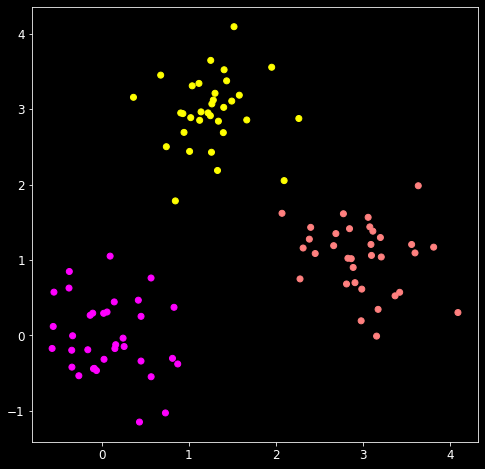

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers = [[0,0],[3,1],[1,3]], n_features=2, n_samples=100,cluster_std=[0.5, 0.5, 0.5], random_state=1)
plt.scatter(X[:,0], X[:,1], c=y)

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

In [ ]:
def plot_predicted_label(ax, clf, xx, yy, X, t):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    
def plot_prob_density(ax, model, xx, yy, X, t):
    Z = model.calc_prob_density(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
    ax.contour(xx, yy, Z)
    
def plot_result(model, xx, yy, X, t):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(121)
    plot_predicted_label(ax, model, xx, yy, X, t)
    ax = fig.add_subplot(122)
    plot_prob_density(ax, model, xx, yy, X, t)

## 4.2 Results for $K=3$

n_iter : 30
log_likelihood : -225.96744831185995


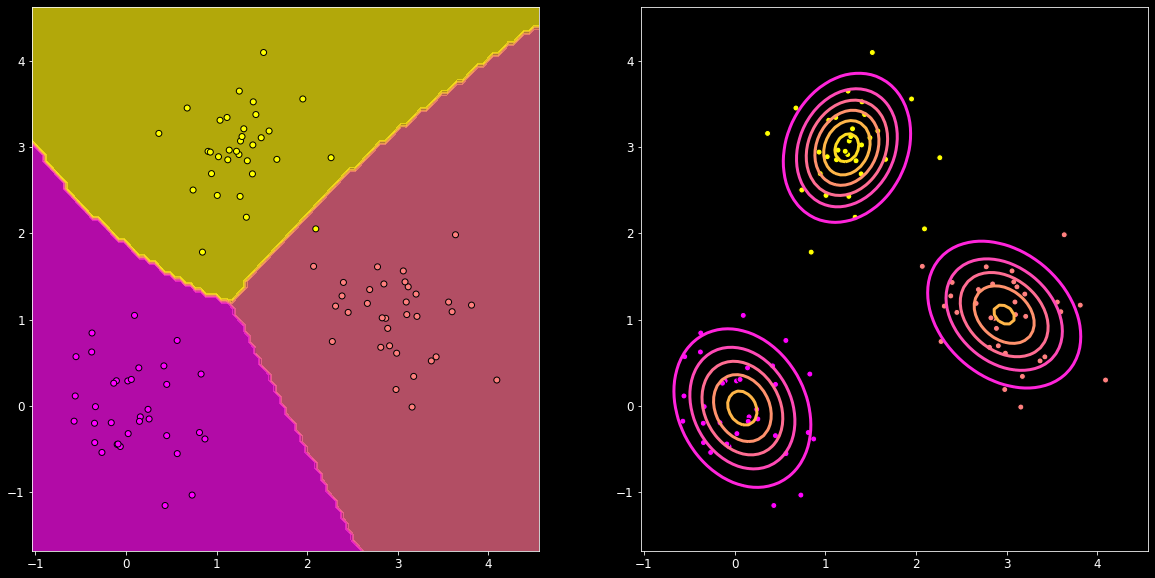

In [ ]:
gmm = GaussianMixtureModel(K=3)
gmm.fit(X, max_iter=30, tol=1e-4, disp_message=True, random_state=0)

plot_result(gmm, xx, yy, X, y)

We can see that the data is properly clustered as we expect intuitively. 
However, depending on the initialization of model parameters, different results can be obtained, as follows:

n_iter : 30
log_likelihood : -255.818526842114


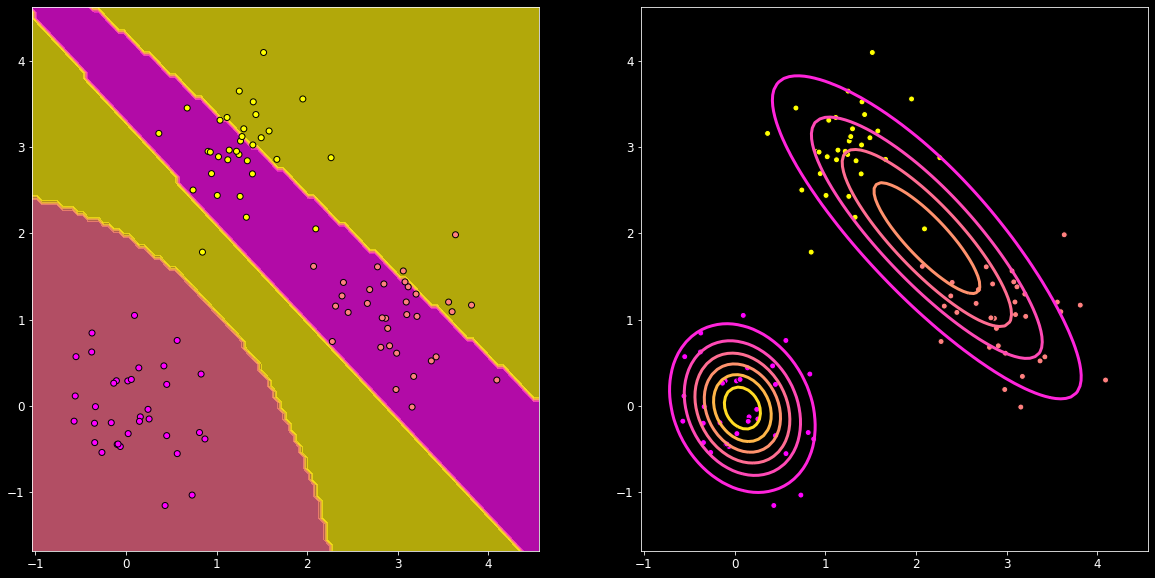

In [ ]:
gmm = GaussianMixtureModel(K=3)
gmm.fit(X, max_iter=30, tol=1e-4, disp_message=True, random_state=1)
plot_result(gmm, xx, yy, X, y)

However, we can see that the former result has larger log-likelihood, and thus it is more appropriate to choose the former result. In reality, we should run fitting several times with different initialization, and choose the result with largest log-likelihood.

## Varying number of clusters $K$


K = 1
n_iter : 3
log_likelihood : -333.4657343576401


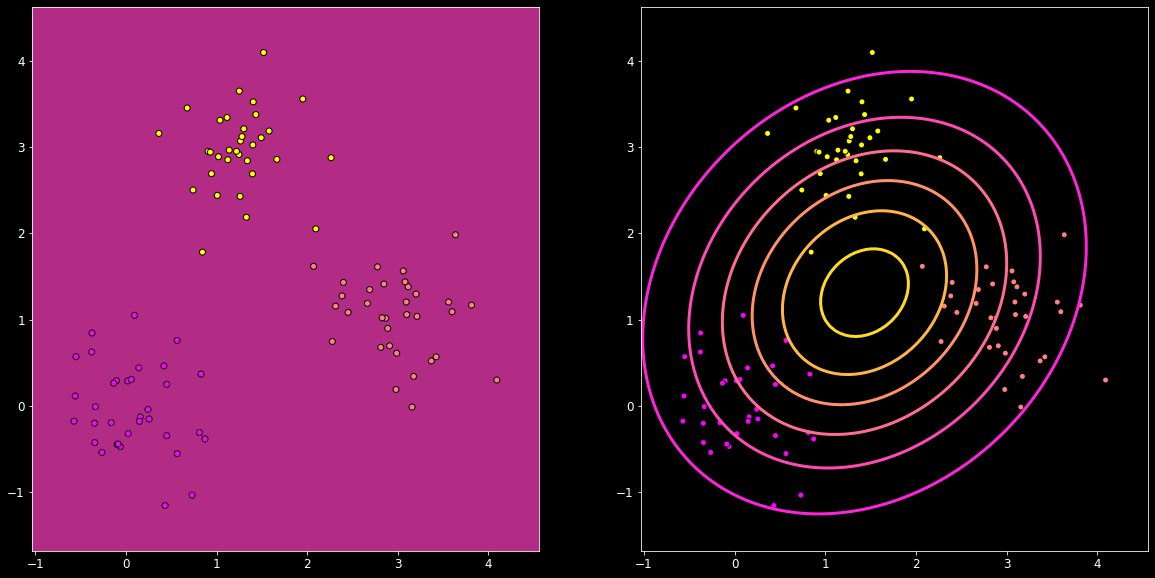

K = 2
n_iter : 17
log_likelihood : -268.661513645507


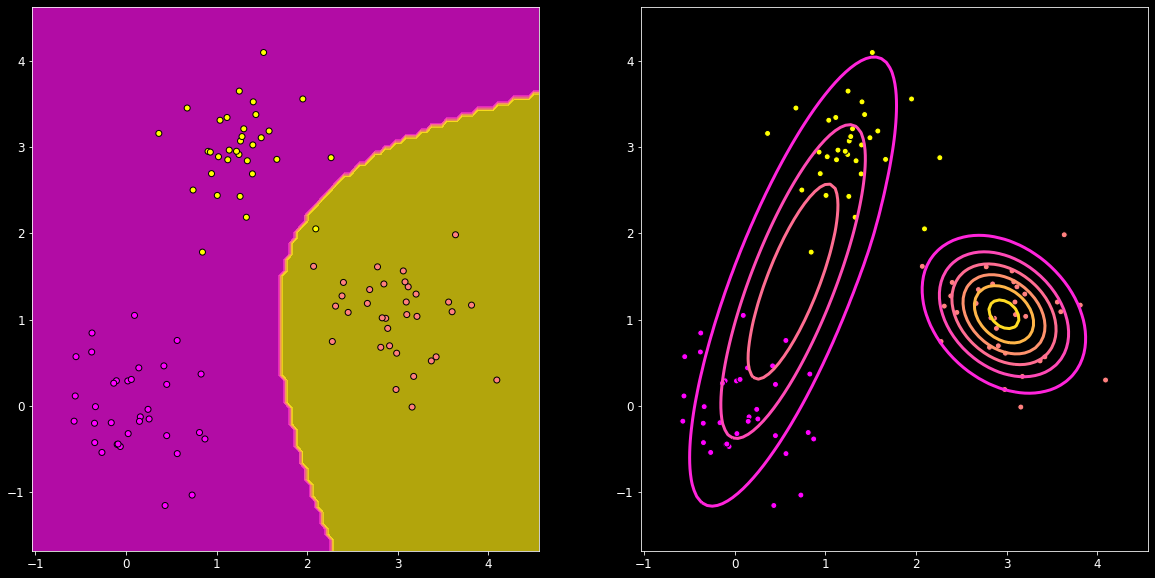

K = 3
n_iter : 34
log_likelihood : -225.89069543735908


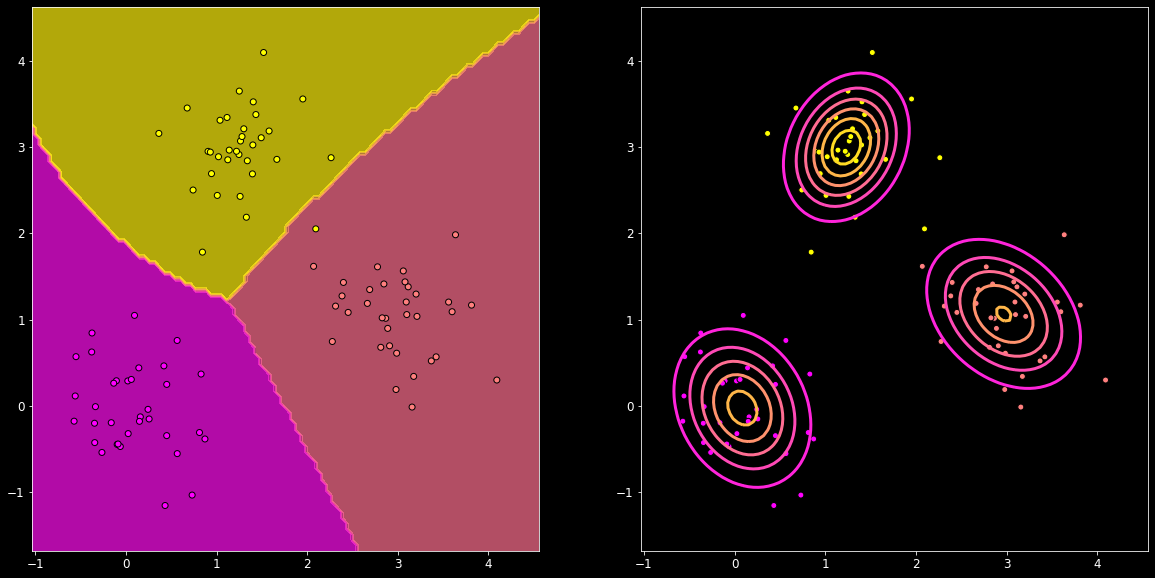

K = 4
n_iter : 57
log_likelihood : -223.43614631657687


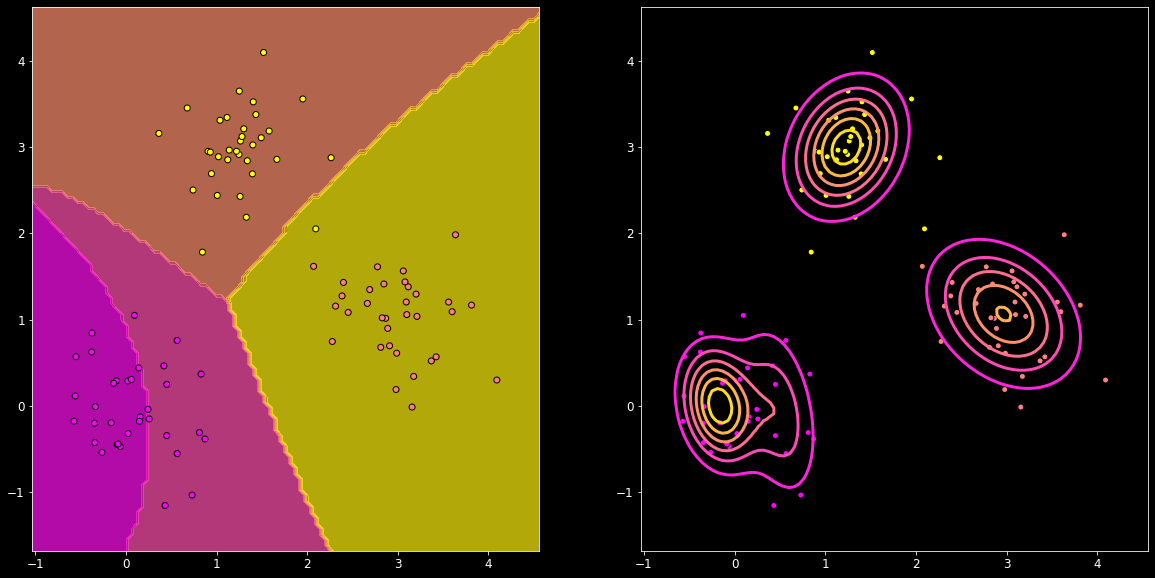

In [ ]:
for K in [1, 2, 3, 4]:
    print(f"K = {K}")
    gmm = GaussianMixtureModel(K=K)
    gmm.fit(X, max_iter=1000, tol=1e-4, disp_message=True, random_state=0)
    plot_result(gmm, xx, yy, X, y)
    plt.show()

K = 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


n_iter : 1000
log_likelihood : nan


/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


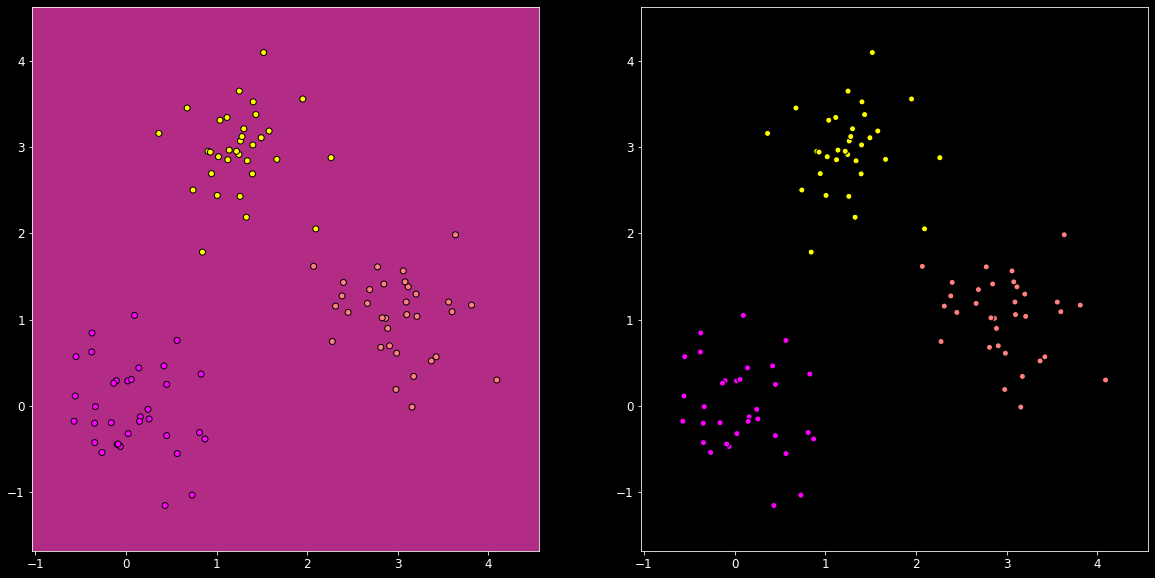

In [ ]:
K = 8
print(f"K = {K}")
gmm = GaussianMixtureModel(K=K)
gmm.fit(X, max_iter=1000, tol=1e-4, disp_message=True, random_state=0)
plot_result(gmm, xx, yy, X, y)
plt.show()